In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.linear_model import LassoCV, RidgeCV
from itertools import product                    
from tqdm import tqdm_notebook
import matplotlib.dates as mdates

import matplotlib.pyplot as plt


#define path
path = "./rnd/*"


print("parsing data...")

# readd all csv files in subfolders
dataFrames = [] 
subfolders = ["./rnd/2013-7","./rnd/2013-8", "./rnd/2013-9"]
for subfolder in subfolders:
    dataFiles = glob.glob(subfolder + "/*.csv")
    
    for dataFile in sorted(dataFiles):
        df = pd.read_csv(
            dataFile,
            sep=";\t",
            engine = "python")
        dataFrames.append(df)
        
# concatenate all data into one data frame
data_frame = pd.concat(dataFrames, axis = 0, ignore_index = True) 
# change timestamp to date 
data_frame['Timestamp [ms]']=(pd.to_datetime(data_frame['Timestamp [ms]'],unit='s')) 
# fill empty values
data_frame.fillna(method='ffill')

# Date Feature Engineering
data_frame['weekday'] = data_frame['Timestamp [ms]'].dt.dayofweek
data_frame['weekend'] = ((data_frame.weekday) // 5 == 1).astype(float)
data_frame['month']=data_frame['Timestamp [ms]'].dt.month 
data_frame['day']=data_frame['Timestamp [ms]'].dt.day
data_frame.set_index('Timestamp [ms]',inplace=True)

# Usage Feature Engineering
data_frame["CPU usage prev"] = data_frame['CPU usage [%]'].shift(1)
data_frame["CPU_diff"] = data_frame['CPU usage [%]'] - data_frame["CPU usage prev"]
data_frame["received_prev"] = data_frame['Network received throughput [KB/s]'].shift(1)
data_frame["received_diff"] = data_frame['Network received throughput [KB/s]']- data_frame["received_prev"]
data_frame["transmitted_prev"] = data_frame['Network transmitted throughput [KB/s]'].shift(1)
data_frame["transmitted_diff"] = data_frame['Network transmitted throughput [KB/s]']- data_frame["transmitted_prev"]

data_frame.head()



parsing data...


,CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],weekday,weekend,month,day,CPU usage prev,CPU_diff,received_prev,received_diff,transmitted_prev,transmitted_diff
Timestamp [ms],,,,,,,,,,,,,,,,,,,,
2013-06-30 22:03:24,2,5851.9989,87.779984,1.500000,8218624.0,1.034593e+06,160.866667,21.733333,0.266667,1.466667,6,1.0,6,30,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30 22:08:24,2,5851.9989,29.259995,0.500000,8218624.0,4.585755e+05,0.000000,2.333333,0.200000,1.000000,6,1.0,6,30,1.500000,-1.000000,0.266667,-0.066667,1.466667,-0.466667
2013-06-30 22:13:24,2,5851.9989,27.309328,0.466667,8218624.0,1.845480e+05,32.066667,4.200000,0.133333,1.066667,6,1.0,6,30,0.500000,-0.033333,0.200000,-0.066667,1.000000,0.066667
2013-06-30 22:18:24,2,5851.9989,23.407996,0.400000,8218624.0,7.829227e+04,0.000000,0.866667,0.066667,1.000000,6,1.0,6,30,0.466667,-0.066667,0.133333,-0.066667,1.066667,-0.066667
2013-06-30 22:23:24,2,5851.9989,19.506663,0.333333,8218624.0,1.677720e+05,0.000000,0.200000,0.133333,1.000000,6,1.0,6,30,0.400000,-0.066667,0.066667,0.066667,1.000000,0.000000


In [23]:
# change the granularity of the data to hours
data_frame = data_frame.resample('H', ).sum()


In [24]:
data_frame.agg({'CPU capacity provisioned [MHZ]': [max, np.mean], 'CPU usage [MHZ]': [max,np.mean]})

,CPU capacity provisioned [MHZ],CPU usage [MHZ]
max,4.684557e+07,1.262710e+07
mean,4.255355e+07,4.699483e+06


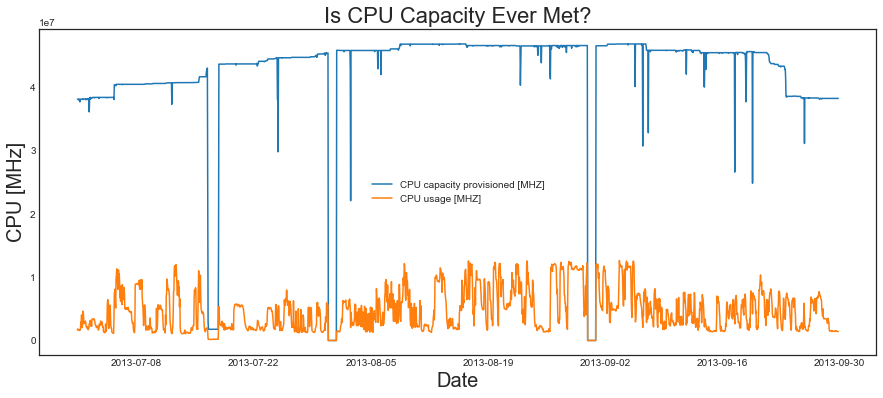

In [25]:
x = data_frame.index
y1 = data_frame['CPU capacity provisioned [MHZ]']
y2 = data_frame['CPU usage [MHZ]']

plt.title('Is CPU Capacity Ever Met?',fontsize=22)
plt.ylabel((r'CPU [MHz]'), fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.rcParams['figure.figsize'] = [15, 6]
plt.plot(x, y1, label='CPU capacity provisioned [MHZ]')
plt.plot(x, y2, label="CPU usage [MHZ]")
plt.legend()
plt.savefig('CPU-provision-ever-met.png')
plt.show()

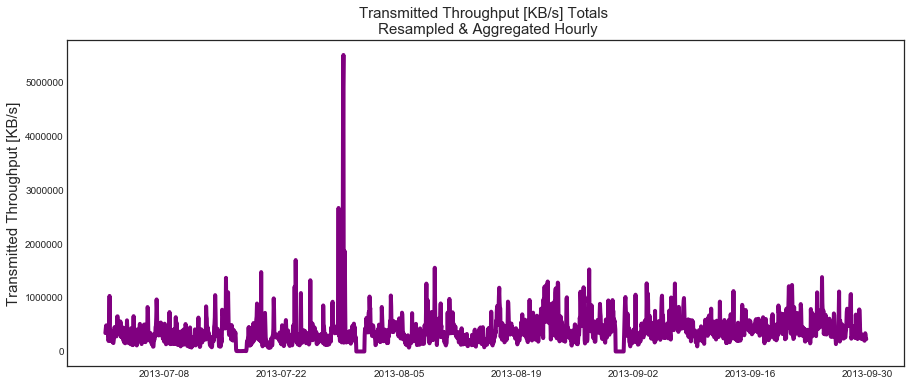

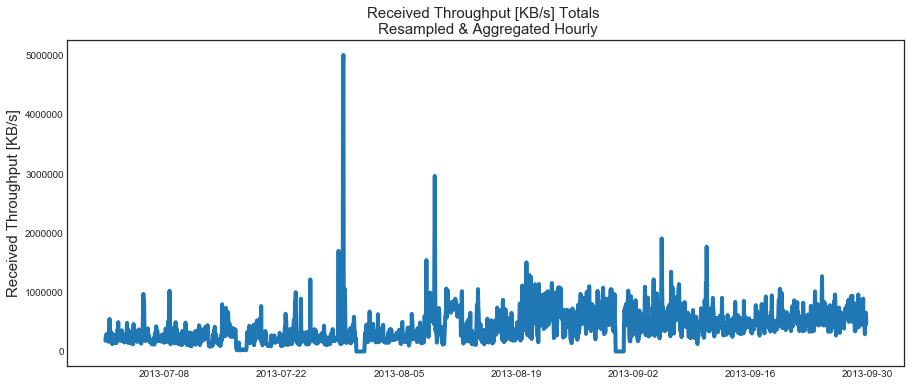

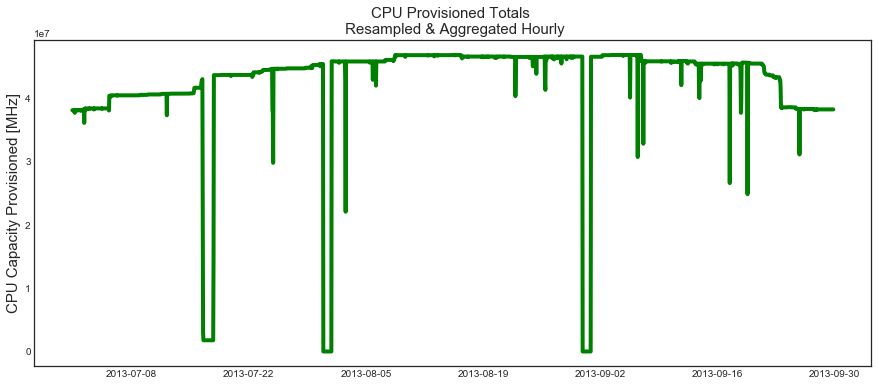

In [26]:
y = data_frame['Network transmitted throughput [KB/s]']
plt.title('Transmitted Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Transmitted Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.plot(x, y, color = "purple",linewidth = 4)
plt.savefig('network-transmitted.png')
plt.show()




y = data_frame['Network received throughput [KB/s]']
plt.title('Received Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Received Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.plot(x, y, linewidth = 4)
plt.savefig('network-received.png')
plt.show()



y = data_frame['CPU capacity provisioned [MHZ]']
plt.title('CPU Provisioned Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('CPU Capacity Provisioned [MHz]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.plot(x, y, color = "g", linewidth = 4)
plt.savefig('provisioned.png')
plt.show()





In [27]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# calculate average for last n observation - for the current window
def moving_average(series, n):
    return np.average(series[-n:])


# a function that computes and plots moving average
        # series - dataframe with timeseries
        # window - rolling window size 
        # plot_intervals - lower/upper band
        # plot_anomalies - show anomalies 
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15,7))
    plt.title("Moving Average (window size = {})".format(window), fontsize = 20)
    plt.ylabel('CPU usage [MHz]   $e^{7}$', fontsize=16);
    plt.xlabel('Time', fontsize=16);
    plt.yticks(fontsize=15);
    plt.xticks(fontsize=15);
    plt.plot(rolling_mean, "purple", label="Rolling Mean Trend",linewidth = 5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper/Lower Bound", linewidth = 1)
        plt.plot(lower_bond, "r--", linewidth = 1)
        
        # find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10, label = "Anomalies")
        
    plt.plot(series[window:], label="Actual CPU Usage", linewidth = 1)
    plt.legend(loc="upper right", fontsize =13)
    plt.grid(True)
    plt.savefig('movingAverage.png')




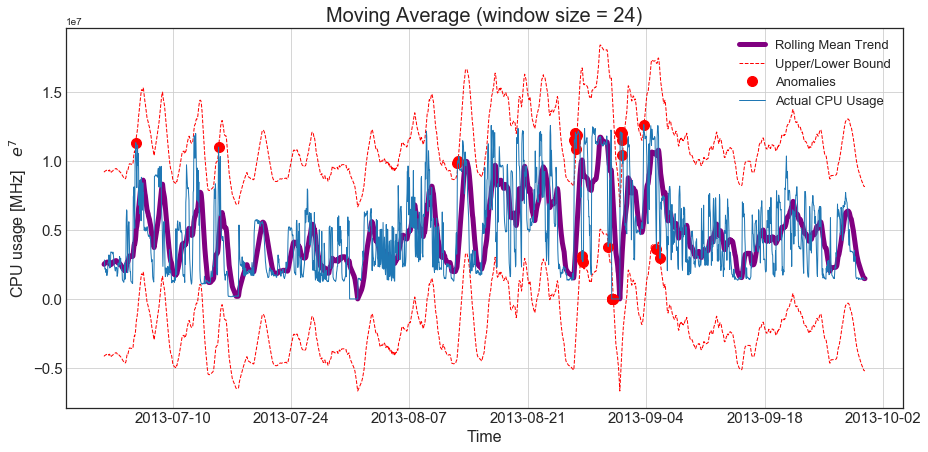

In [28]:
## make 24 hour windows
plotMovingAverage(data_frame[['CPU usage [MHZ]']], 24, plot_intervals=True, plot_anomalies=True)


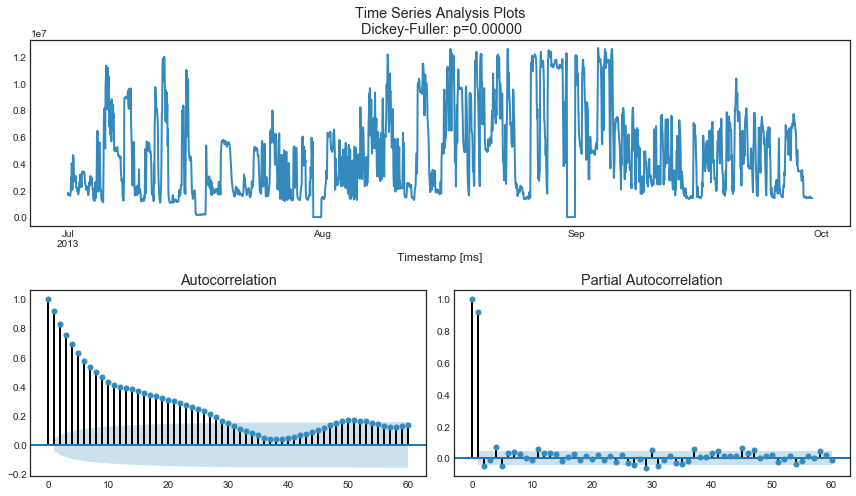

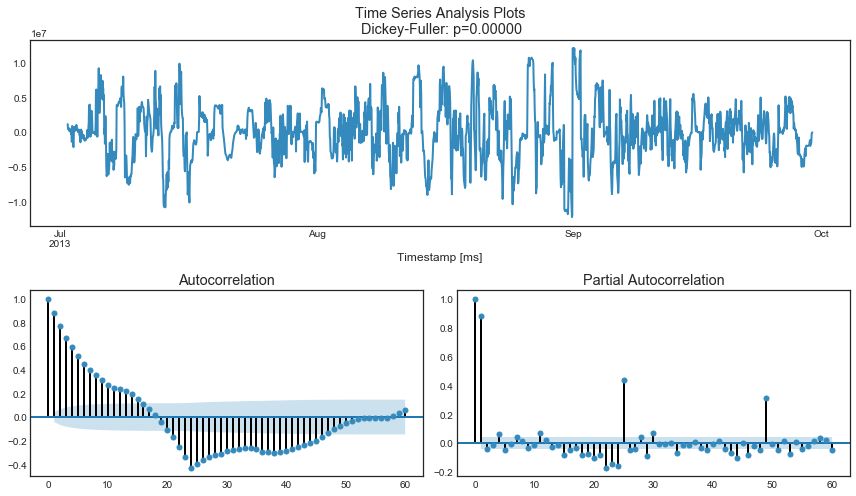

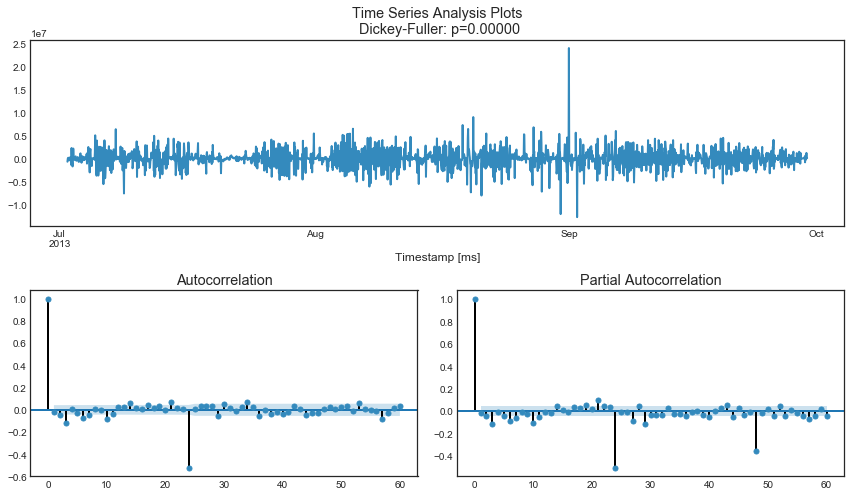

In [29]:
 # IMPORTANT -> check if we have stationary series
 #        Plot time series, its autocorrelation and partial autocorrelation, calculate Dickey–Fuller test
 #       y: timeseries
 #       lags: time-lags: how many lags to include in AC, PAC calculation


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
   
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        plt.style.use('seaborn-white')
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        # p_value test < 0.5 suggest that we have an stationary time series
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        
        
tsplot(data_frame['CPU usage [MHZ]'], lags=60)
ads_diff = data_frame['CPU usage [MHZ]'] - data_frame['CPU usage [MHZ]'].shift(24)
tsplot(ads_diff[24:], lags=60)
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)
        
        

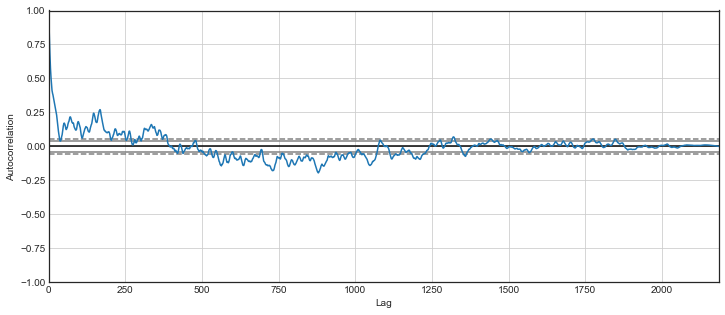

In [49]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(data_frame['CPU usage [MHZ]']);
plt.savefig('autocorelation.png')



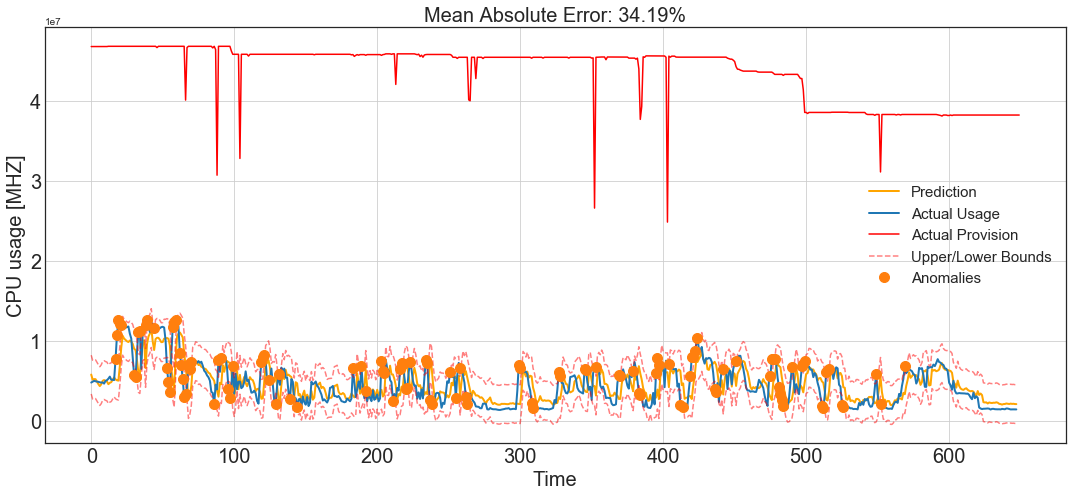

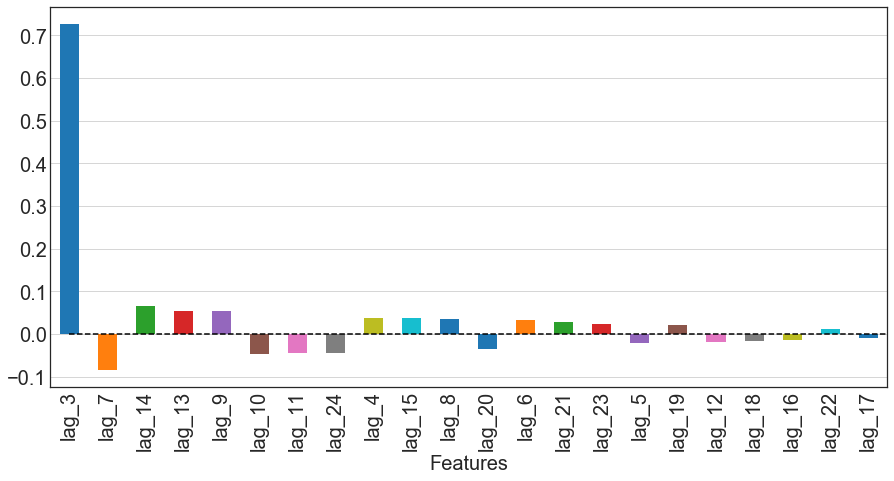

In [59]:
# MODELING
#### LINEAR REGRESSION MODEL ####

import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


        #params - vector of parameters for optimization
        #series - dataset with timeseries
        #slen - season length for Holt-Winters model
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


def plotCoefficients(model):
  
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.tick_params(labelsize=20)
    plt.xlabel("Features", fontsize = 20) 
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    plt.savefig('lasso.png')



data = pd.DataFrame(data_frame['CPU usage [MHZ]'].copy())
data.columns = ["y"]

# Adding the lag of the target variable from 3 steps (hours) up to 24
for i in range(3, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)


def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
        
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "orange", label="Prediction", linewidth=2.0)
    plt.plot(y_test.values,label="Actual Usage", linewidth=2.0)
   
    ## these two lines are for see the actual provision
    act_prov = data_frame['CPU capacity provisioned [MHZ]'].tail(650).values
    plt.plot(act_prov, color='red',label = "Actual Provision")
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="Upper/Lower Bounds", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        plt.tick_params(labelsize=20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean Absolute Error: {0:.2f}%".format(error),  fontsize = 20)
    plt.legend(loc="best", fontsize = 15)
    plt.tight_layout()
    plt.grid(True);
    plt.savefig('linear-regrression2.png')
    
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3) 
    
#linear reg
model = LinearRegression()
model.fit(X_train, y_train)

plotModelResults(model, plot_intervals=True, plot_anomalies=True)
plotCoefficients(model)

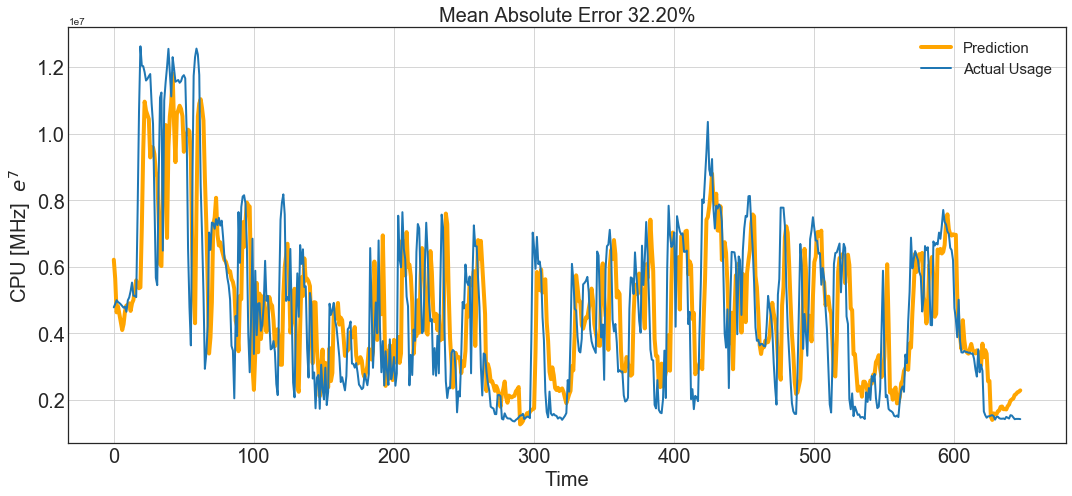

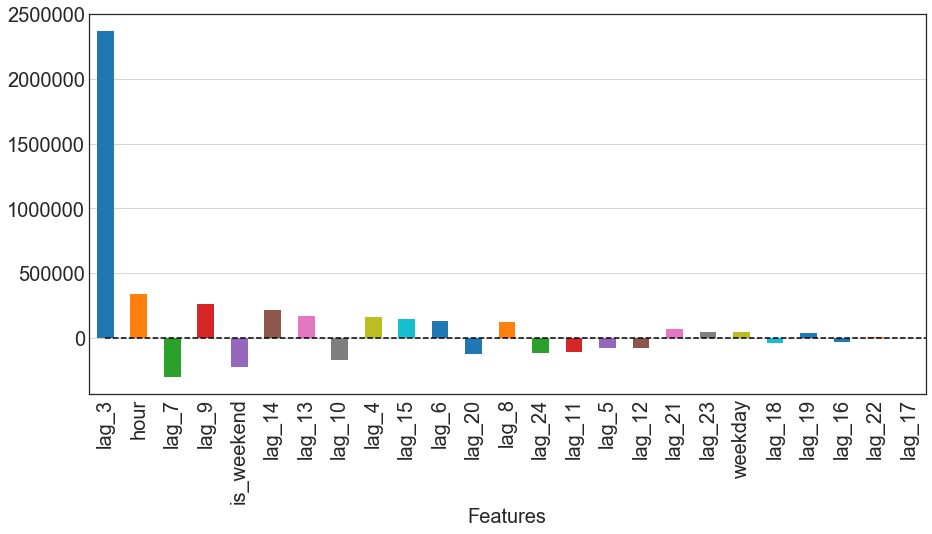

In [68]:
##### SCALED LINEAR REGRESSION ######

data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1


def plotModelResultsScaler(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "orange", label="Prediction", linewidth=4.0)
    plt.plot(y_test.values,label="Actual Usage", linewidth=2.0)
        
    #plt.plot(capprv.values, color='red',label = "Actual Provision")
    
    plt.ylabel("CPU usage [MHZ]", fontsize = 20)
    plt.xlabel("Time", fontsize = 20) 
    plt.tick_params(labelsize=20)
    plt.ylabel('CPU [MHz]  $e^{7}$', fontsize=20);
    plt.xlabel("Time", fontsize = 20) 
   
 ## these two lines are for see the actual provision
    #act_prov = data_frame['CPU capacity provisioned [MHZ]'].tail(650).values
    #plt.plot(act_prov, color='red',label = "Actual Provision")
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "b--", label="Upper/Lower Bounds", alpha=0.5, linewidth=1)
        plt.plot(upper, "b--", alpha=0.5, linewidth=1)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean Absolute Error {0:.2f}%".format(error), fontsize = 20)
    plt.legend(loc="best", fontsize =15)
    plt.tight_layout()
    plt.grid(True);
    plt.savefig('scaled-lin-reg.png')
    
    
    
    
    
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr2, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=False, plot_anomalies=False)
plotCoefficients(lr2)


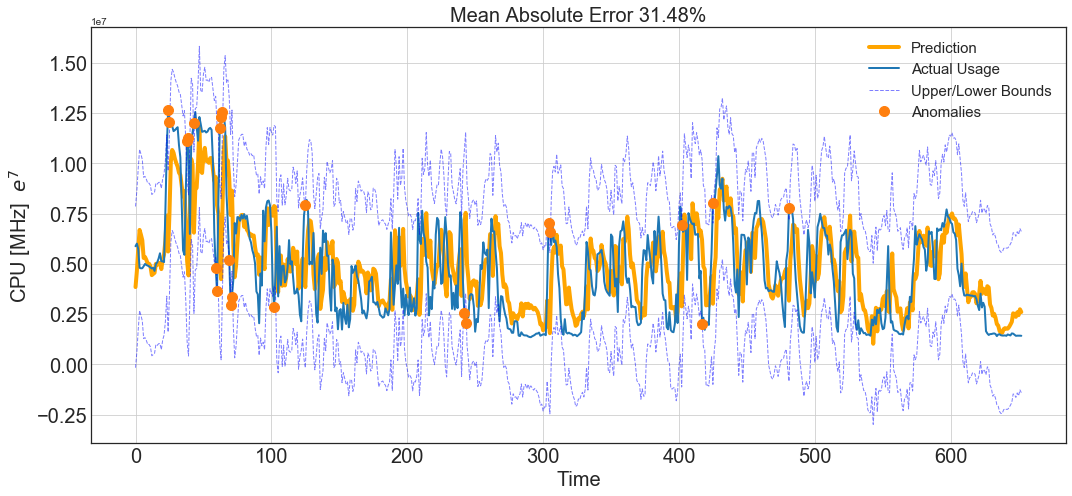

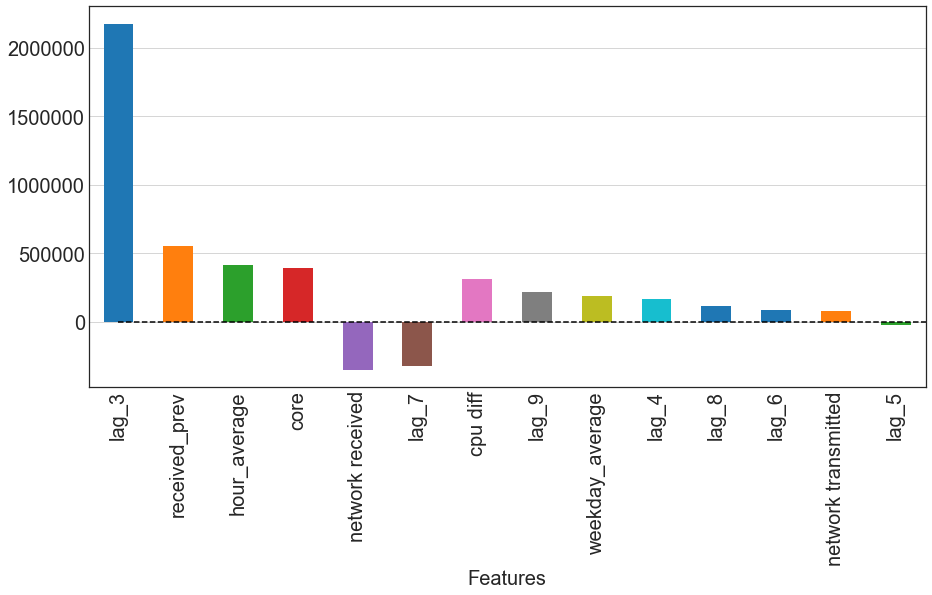

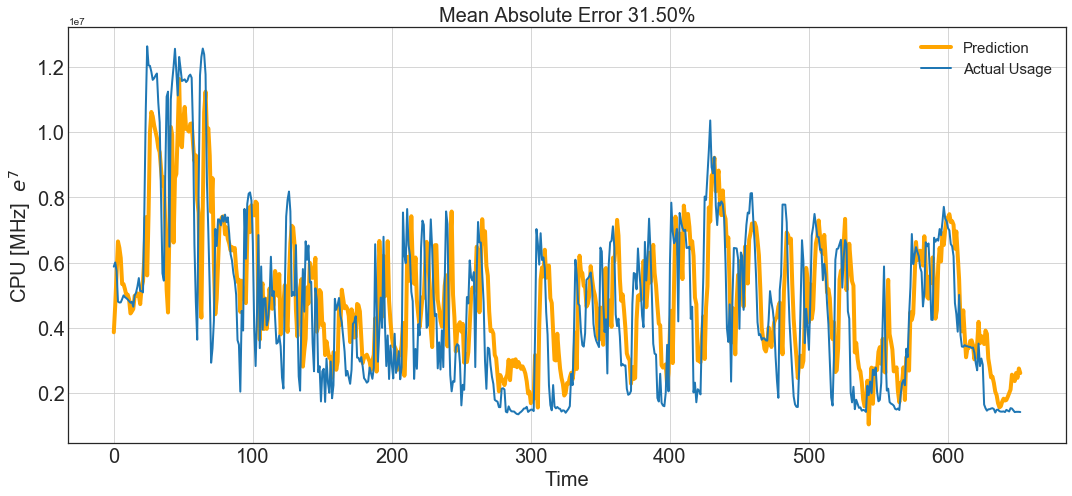

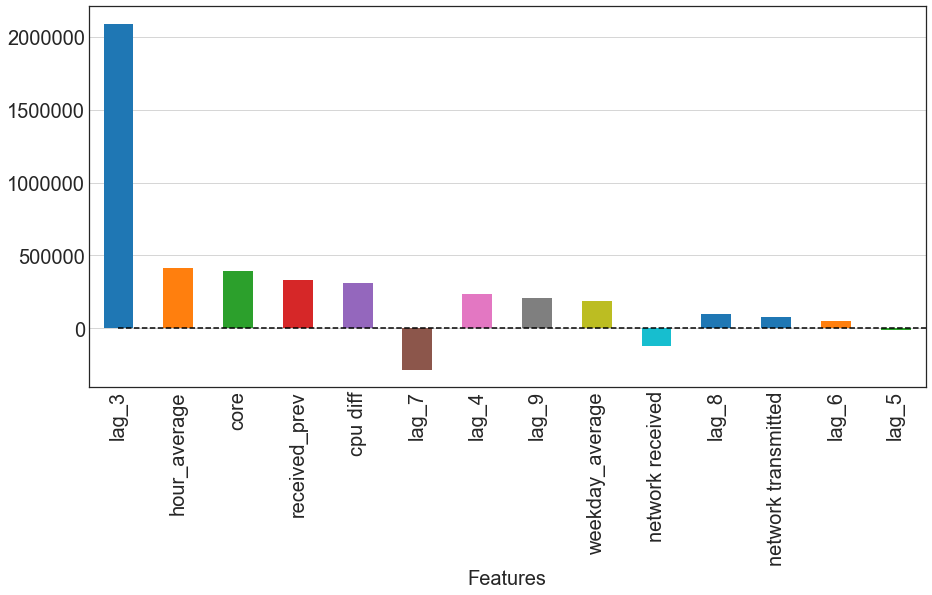

In [65]:
### scaled Ridge regression ###

## data preparation ##

# dictionary with unique categories, values are means
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

# target encoding - adds target averages to the dataset
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    # other features
    data['network received'] = data_frame[['Network received throughput [KB/s]']]
    data['network transmitted'] = data_frame[['Network transmitted throughput [KB/s]']]
    data['cpu diff'] = data_frame[['CPU_diff']]
    data['received_prev'] = data_frame[['received_prev']]
    data['core'] = data_frame[['CPU cores']]

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))
        
        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test =\
prepareData(data_frame[['CPU usage [MHZ]']], lag_start=3, lag_end=10, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResultsScaler(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=False, plot_anomalies=False)
plt.savefig('scaled_ridge_regression.png')

plotCoefficients(ridge)


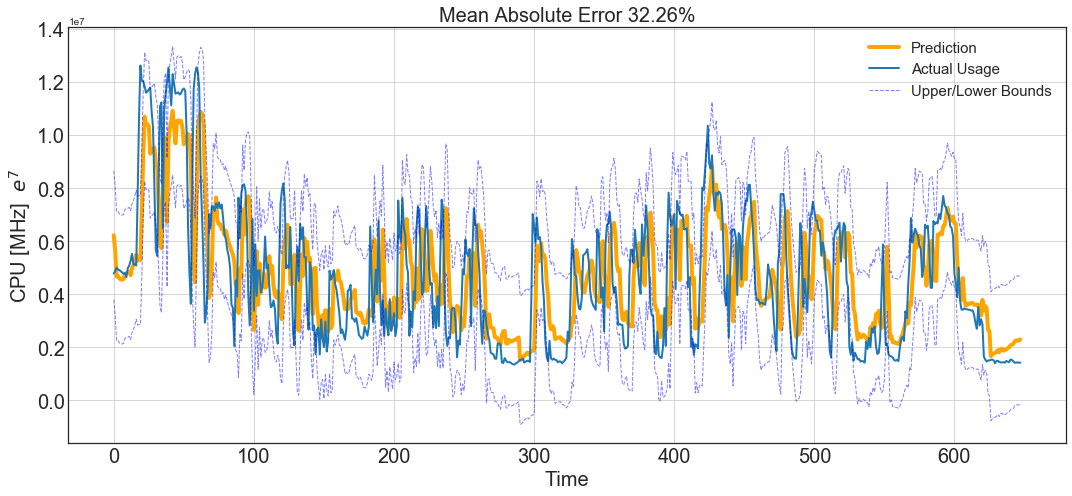

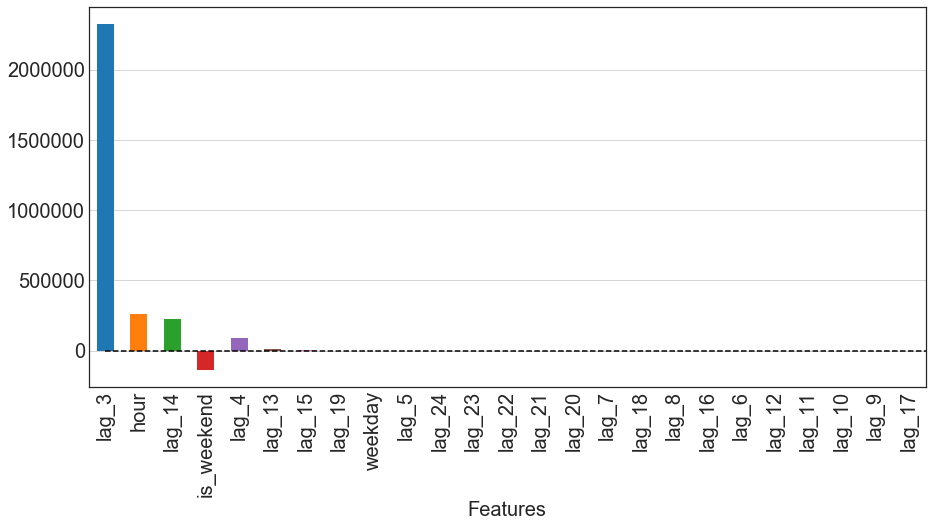

In [70]:
### Lasso Regression ### 
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResultsScaler(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=False)
plotCoefficients(lasso)
